In [3]:
from transformers import pipeline
import pandas as pd
import re
from tqdm import tqdm

d:\Code\Amazon ML Challenge\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [107]:
qa_pipeline = pipeline('question-answering', model="deepset/roberta-base-squad2-distilled", device='cuda')
# qa_pipeline = pipeline('question-answering', model="deepset/roberta-base-squad2", device=0)
context = ""
question = "Answer the numerical value with the relevant unit. What is the %% mentioned in the description?"
depth_question = "Answer the numerical values with the relevant units. What are the lengths mentioned in the description?"

d:\Code\Amazon ML Challenge\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [117]:
def process_text(answer, entity):
    # Clean up the output of the LLM
    entity_unit_map = {
        "width": {"centimetre", "foot", "millimetre", "metre", "inch", "yard"},
        "depth": {"centimetre", "foot", "millimetre", "metre", "inch", "yard"},
        "height": {"centimetre", "foot", "millimetre", "metre", "inch", "yard"},
        "item_weight": {
            "milligram",
            "kilogram",
            "microgram",
            "gram",
            "ounce",
            "ton",
            "pound",
        },
        "voltage": {"millivolt", "kilovolt", "volt"},
        "wattage": {"kilowatt", "watt"},
        "item_volume": {
            "cubic foot",
            "microlitre",
            "cup",
            "fluid ounce",
            "centilitre",
            "imperial gallon",
            "pint",
            "decilitre",
            "litre",
            "millilitre",
            "quart",
            "cubic inch",
            "gallon",
            "ounce",
        },
        "maximum_weight_recommendation": {
            "milligram",
            "kilogram",
            "microgram",
            "gram",
            "ounce",
            "ton",
            "pound",
        },
    }
    unit_short_form = {
        "cm": "centimetre",
        "mm": "millimetre",
        "m": "metre",
        "in": "inch",
        "ft": "foot",
        "yd": "yard",
        "g": "gram",
        "kg": "kilogram",
        "mg": "milligram",
        "lb": "pound",
        "oz": "ounce",
        "ton": "ton",
        "ug": "microgram",
        "lbs": "pound",
        "9": "gram",
        "ozs": "ounce",
        "mv": "millivolt",
        "kv": "kilovolt",
        "v": "volt",
        "kw": "kilowatt",
        "w": "watt",
        "cf": "cubic foot",
        "ul": "microlitre",
        "fl oz": "fluid ounce",
        "cl": "centilitre",
        "gal": "imperial gallon",
        "pt": "pint",
        "dl": "decilitre",
        "l": "litre",
        "ml": "millilitre",
        "qt": "quart",
        "cu in": "cubic inch",
        "gals": "gallon",
        "c in": "cubic inch",
        "cu ft": "cubic foot",
        "o2": "ounce",
        "0z": "ounce",
        "k9": "kilogram",
        "\'\'": "inch",
        "``": "inch",
        "\"": "inch",
        # If no unit is mentioned, assume it is inches
        "": "inch",
        "c": "centimetre",
    }
    # Replace common OCR errors
    answer = answer.replace(",", ".")


    entity_unit = entity_unit_map[entity]
    regex_map = {
        "item_weight": r"[0-9IJOQSZDLB]+(\.[0-9IJOQSZDLB]+)?\s*(g|kg|mg|ug|oz|ton|lb|lbs|Ibs|bs|1bs|ozs|o2|0z|k9|kilo|milli|micro|ounce|tonne|pound|gram)",
        "width": r"[0-9IJOQSZDLB]+(\.[0-9IJOQSZDLB]+)?\s*(c|cm|mm|m|in|ft|yd|centi|milli|inch|foot|yard|\'\'|``|\"|feet)",
        "depth": r"[0-9IJOQSZDLB]+(\.[0-9IJOQSZDLB]+)?\s*(c|cm|mm|m|in|ft|yd|centi|milli|inch|foot|yard|\'\'|``|\"|feet)",
        "height": r"[0-9IJOQSZDLB]+(\.[0-9IJOQSZDLB]+)?\s*(c|cm|mm|m|in|ft|yd|centi|milli|inch|foot|yard|\'\'|``|\"|feet)",
        "voltage": r"[0-9IJOQSZDLB]+(\.[0-9IJOQSZDLB]+)?\s*(mv|kv|v|milli|kilo)",
        "wattage": r"[0-9IJOQSZDLB]+(\.[0-9IJOQSZDLB]+)?\s*(kw|w|kilo)",
        "item_volume": r"[0-9IJOQSZDLB]+(\.[0-9IJOQSZDLB]+)?\s*(cf|ul|fl oz|cl|gal|pt|dl|l|ml|qt|cu in|gals|c in|cu ft|o2|oz|ozs|0z|cubic|micro|cup|fluid|centi|imperial|pint|decilitre|litre|millilitre|quart|gallon|ounce)",
        "maximum_weight_recommendation": r"[0-9IJOQSZDLB]+(\.[0-9IJOQSZDLB]+)?\s*(g|kg|mg|ug|oz|ton|lb|lbs|Ibs|bs|1bs|ozs|o2|02|0z|k9|kilo|milli|micro|ounce|tonne|pound|gram)",
    }
    reverse_regex_map = {
        "item_weight": r"\s*(g|kg|mg|ug|oz|ton|lb|lbs|Ibs|bs|1bs|ozs|o2|0z|k9|kilo|milli|micro|ounce|tonne|pound|gram)\s*[0-9IJOQSZDLB]+(\.[0-9IJOQSZDLB]+)?",
        "width": r"\s*(c|cm|mm|m|in|ft|yd|centi|milli|inch|foot|yard|\'\'|``|\"|feet)\s*[0-9IJOQSZDLB]+(\.[0-9IJOQSZDLB]+)?",
        "depth": r"\s*(c|cm|mm|m|in|ft|yd|centi|milli|inch|foot|yard|\'\'|``|\"|feet)\s*[0-9IJOQSZDLB]+(\.[0-9IJOQSZDLB]+)?",
        "height": r"\s*(c|cm|mm|m|in|ft|yd|centi|milli|inch|foot|yard|\'\'|``|\"|feet)\s*[0-9IJOQSZDLB]+(\.[0-9IJOQSZDLB]+)?",
        "voltage": r"\s*(mv|kv|v|milli|kilo)\s*[0-9IJOQSZDLB]+(\.[0-9IJOQSZDLB]+)?",
        "wattage": r"\s*(kw|w|kilo)\s*[0-9IJOQSZDLB]+(\.[0-9IJOQSZDLB]+)?",
        "item_volume": r"\s*(cf|ul|fl oz|cl|gal|pt|dl|l|ml|qt|cu in|gals|c in|cu ft|o2|oz|ozs|0z|cubic|micro|cup|fluid|centi|imperial|pint|decilitre|litre|millilitre|quart|gallon|ounce)\s*[0-9IJOQSZDLB]+(\.[0-9IJOQSZDLB]+)?",
        "maximum_weight_recommendation": r"\s*(g|kg|mg|ug|oz|ton|lb|lbs|Ibs|bs|1bs|ozs|o2|02|0z|k9|kilo|milli|micro|ounce|tonne|pound|gram)\s*[0-9IJOQSZDLB]+(\.[0-9IJOQSZDLB]+)?",
    }
    regex_units = {
        "item_weight": r"\s*(g|kg|mg|ug|oz|ton|lb|lbs|Ibs|bs|1bs|ozs|o2|0z|k9|kilo|milli|micro|ounce|tonne|pound|gram)",
        "width": r"\s*(c|cm|mm|m|in|ft|yd|centi|milli|inch|foot|yard|\'\'|``|\"|feet)",
        "depth": r"\s*(c|cm|mm|m|in|ft|yd|centi|milli|inch|foot|yard|\'\'|``|\"|feet)",
        "height": r"\s*(c|cm|mm|m|in|ft|yd|centi|milli|inch|foot|yard|\'\'|``|\"|feet)",
        "voltage": r"\s*(mv|kv|v|milli|kilo)",
        "wattage": r"\s*(kw|w|kilo)",
        "item_volume": r"\s*(cf|ul|fl oz|cl|gal|pt|dl|l|ml|qt|cu in|gals|c in|cu ft|o2|oz|ozs|0z|cubic|micro|cup|fluid|centi|imperial|pint|decilitre|litre|millilitre|quart|gallon|ounce)",
        "maximum_weight_recommendation": r"\s*(g|kg|mg|ug|oz|ton|lb|lbs|Ibs|bs|1bs|ozs|o2|0z|k9|kilo|milli|micro|ounce|tonne|pound|gram)",
    }
    # Remove igh which will cause false positives
    answer = answer.replace("igh", "")
    # Remove ima which will cause false positives
    answer = answer.replace("ima", "")
    # Replace comma with dot
    answer = answer.replace(",", ".")
    # Match the regex ignoring case
    match = re.finditer(regex_map[entity], answer, re.IGNORECASE)
    reverse_match = re.finditer(reverse_regex_map[entity], answer, re.IGNORECASE)
    
    # Process each match
    for m in match:
        # Extract the number and the unit
        # Extract the matched value
        value = m.group(0)
        # Extract the unit
        unit = re.search(
            regex_units[entity], value, re.IGNORECASE
        )
        if (entity == "height" or entity == "width") and not unit:
            unit = "inch"
            sstr = ""
        elif not unit:
            continue
        else:
            unit = unit.group(0).strip()
            sstr = unit
            unit = unit.lower()
        if unit == "feet":
            unit = "foot"
        # Convert the unit to full form
        if unit in unit_short_form:
            unit = unit_short_form[unit]
        # Check if the unit is valid
        if unit in entity_unit:
            entity_value = value[: value.index(sstr)].strip()
            # Replace I with 1 and O with 0
            entity_value = (
                entity_value.replace("I", "1")
                .replace("i", "1")
                .replace("J", "1")
                .replace("j", "1")
                .replace("O", "0")
                .replace("o", "0")
                .replace("D", "0")
                .replace("B", "8")
                .replace("b", "6")
                .replace("L", "1")
                .replace("l", "1")
                .replace("S", "5")
                .replace("s", "5")
                .replace("Z", "2")
                .replace("z", "2")
                .replace("Q", "0")
                .replace("q", "9")
            )
            try:
                entity_value = float(entity_value)
                if int(entity_value) == entity_value and entity_value > 1000:
                    entity_value = int(entity_value)
            except:
                continue
            return str(entity_value) + " " + unit
    for m in reverse_match:
        value = m.group(0)
        unit = re.search(
            regex_units[entity], value, re.IGNORECASE
        )
        if entity == "height" and not unit:
            unit = "inch"
            sstr = ""
        elif not unit:
            continue
        else:
            unit = unit.group(0).strip()
            sstr = unit
            unit = unit.lower()
        if unit == "feet":
            unit = "foot"
        # Convert the unit to full form
        if unit in unit_short_form:
            unit = unit_short_form[unit]
        # Check if the unit is valid
        if unit in entity_unit:
            entity_value = value.replace(sstr, "").strip()
            # Replace I with 1 and O with 0
            entity_value = (
                entity_value.replace("I", "1")
                .replace("i", "1")
                .replace("J", "1")
                .replace("j", "1")
                .replace("O", "0")
                .replace("o", "0")
                .replace("D", "0")
                .replace("B", "8")
                .replace("b", "6")
                .replace("L", "1")
                .replace("l", "1")
                .replace("S", "5")
                .replace("s", "5")
                .replace("Z", "2")
                .replace("z", "2")
                .replace("Q", "0")
                .replace("q", "9")
            )
            try:
                # Reverse the value
                entity_value = entity_value[::-1]
                entity_value = str("".join([s for s in entity_value if s.isdigit()]))
                entity_value = float(entity_value)
                if int(entity_value) == entity_value and entity_value > 1000:
                    entity_value = int(entity_value)
            except:
                continue
            return str(entity_value) + " " + unit
    return None

In [109]:
# for text in texts['Extracted Text']:
#     context = text
#     c_question = question.replace("%%", "item_weight")
#     result = qa_pipeline(question=c_question, context=context)
#     print(f"Question: {c_question}\nText: {text}\nAnswer: {result['answer']}")
#     print(f"Processed Answer: {process_text(result['answer'], 'item_weight')}")
#     print("")

In [118]:
edge_cases = [
    "100-240V 60W",
]
# for case in edge_cases:
#     print(f"Edge Case: {case}\nProcessed Answer: {process_text(case, 'voltage')}")
#     print("")

edge_cases = [
    "cm 69",
    '"23.95"""',
]
for case in edge_cases:
    print(f"Edge Case: {case}\nProcessed Answer: {process_text(case, 'height')}")
    print("")

edge_cases = [
    "202g",
    "2ODgm Weight",
    "2k9",
    "SOY CLEANEST BURNING WAX 2 0z",
    "140Omg per serving",
    "2 x Mint Buttons 95g",
    "1 Kg 22242",
    "ktikin I5kG",
    "2ml/o.O6oz",
    "6x17g",
    "J g",
    "10Og",
    "0.24 LBS",
    "36 9",
    "5KG WATERPROOF LOAD BEARING",
    "MiLB/454 G DJARK ROAST BLUE 1007",
]

for case in edge_cases:
    print(f"Edge Case: {case}\nProcessed Answer: {process_text(case, 'item_weight')}")
    print("")


Edge Case: cm 69
Processed Answer: 96.0 centimetre

Edge Case: "23.95"""
Processed Answer: 23.95 inch

Edge Case: 202g
Processed Answer: 202.0 gram

Edge Case: 2ODgm Weight
Processed Answer: 200.0 gram

Edge Case: 2k9
Processed Answer: 2.0 kilogram

Edge Case: SOY CLEANEST BURNING WAX 2 0z
Processed Answer: 2.0 ounce

Edge Case: 140Omg per serving
Processed Answer: 1400 milligram

Edge Case: 2 x Mint Buttons 95g
Processed Answer: 95.0 gram

Edge Case: 1 Kg 22242
Processed Answer: 1.0 kilogram

Edge Case: ktikin I5kG
Processed Answer: 15.0 kilogram

Edge Case: 2ml/o.O6oz
Processed Answer: 0.06 ounce

Edge Case: 6x17g
Processed Answer: 17.0 gram

Edge Case: J g
Processed Answer: 1.0 gram

Edge Case: 10Og
Processed Answer: 100.0 gram

Edge Case: 0.24 LBS
Processed Answer: 0.24 pound

Edge Case: 36 9
Processed Answer: None

Edge Case: 5KG WATERPROOF LOAD BEARING
Processed Answer: 5.0 kilogram

Edge Case: MiLB/454 G DJARK ROAST BLUE 1007
Processed Answer: 1.0 pound



In [89]:
train_data = pd.read_csv("../dataset/new_train.csv")
train_data.head()
train_data = train_data.dropna(subset=['extracted_text'])
# train_data2 = train_data[train_data["entity_name"] == "height"]
# Select only the first 100 rows
# train_data = train_data.head(100)

In [97]:
TP, FP, FN, TN = 0, 0, 0, 0
entity_wise_results = {}
for index, row in tqdm(train_data.iterrows(), total=len(train_data)):
# for index, row in train_data.iterrows():
    text = row["extracted_text"]
    if pd.isna(text):
        continue
    entity_name = row["entity_name"]
    context = text
    c_question = question.replace("%%", entity_name) 
    if entity_name == "voltage":
        c_question = voltage_question
    result = qa_pipeline([{"question": c_question, "context": context}])
    OUT = process_text(result["answer"], entity_name)
    if OUT == None:
        OUT = ""
    GT = row["entity_value"]
    # True Positive
    if GT != "" and OUT != "" and GT == OUT:
        TP += 1
        if entity_name not in entity_wise_results:
            entity_wise_results[entity_name] = [0, 0, 0, 0]
        entity_wise_results[entity_name][0] += 1
    # False Positive
    if (GT == "" and OUT != "") or (GT != "" and OUT != "" and GT != OUT):
        FP += 1
        if entity_name not in entity_wise_results:
            entity_wise_results[entity_name] = [0, 0, 0, 0]
        entity_wise_results[entity_name][1] += 1
        # print(
        #     f"Entity: {entity_name}\nImage: {row['image_link']}\nGT: {GT}\nOUT: {OUT}\nText: {text}\nQuestion: {c_question}\nAnswer: {result['answer']}\n"
        # )
    # False Negative
    if GT != "" and OUT == "":
        FN += 1
        if entity_name not in entity_wise_results:
            entity_wise_results[entity_name] = [0, 0, 0, 0]
        entity_wise_results[entity_name][2] += 1
    # True Negative
    if GT == "" and OUT == "":
        TN += 1
        if entity_name not in entity_wise_results:
            entity_wise_results[entity_name] = [0, 0, 0, 0]
        entity_wise_results[entity_name][3] += 1

100%|██████████| 6765/6765 [02:52<00:00, 39.22it/s]


In [98]:
precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1 = 2 * precision * recall / (precision + recall)
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1: {f1}")

Precision: 0.5340659340659341
Recall: 0.3835075951864273
F1: 0.4464347227006545


In [99]:
print(f"TP: {TP}")
print(f"FP: {FP}")
print(f"FN: {FN}")
print(f"TN: {TN}")

TP: 1944
FP: 1696
FN: 3125
TN: 0


In [100]:
entity_wise_results = pd.DataFrame.from_dict(entity_wise_results, orient="index")
entity_wise_results.columns = ["TP", "FP", "FN", "TN"]
entity_wise_results["Precision"] = entity_wise_results["TP"] / (
    entity_wise_results["TP"] + entity_wise_results["FP"]
)
entity_wise_results["Recall"] = entity_wise_results["TP"] / (
    entity_wise_results["TP"] + entity_wise_results["FN"]
)
entity_wise_results["F1"] = 2 * entity_wise_results["Precision"] * entity_wise_results["Recall"] / (
    entity_wise_results["Precision"] + entity_wise_results["Recall"]
)

In [101]:
entity_wise_results = entity_wise_results.sort_values(by="F1", ascending=False)
print(entity_wise_results)

                                 TP    FP    FN  TN  Precision    Recall  \
depth                             6     3     1   0   0.666667  0.857143   
wattage                         172    35   158   0   0.830918  0.521212   
voltage                         168    67   165   0   0.714894  0.504505   
item_weight                    1500  1394  2511   0   0.518314  0.373972   
item_volume                      84   114   169   0   0.424242  0.332016   
height                            1     5     2   0   0.166667  0.333333   
maximum_weight_recommendation    13    76   118   0   0.146067  0.099237   
width                             0     2     1   0   0.000000  0.000000   

                                     F1  
depth                          0.750000  
wattage                        0.640596  
voltage                        0.591549  
item_weight                    0.434468  
item_volume                    0.372506  
height                         0.222222  
maximum_weight_recomm

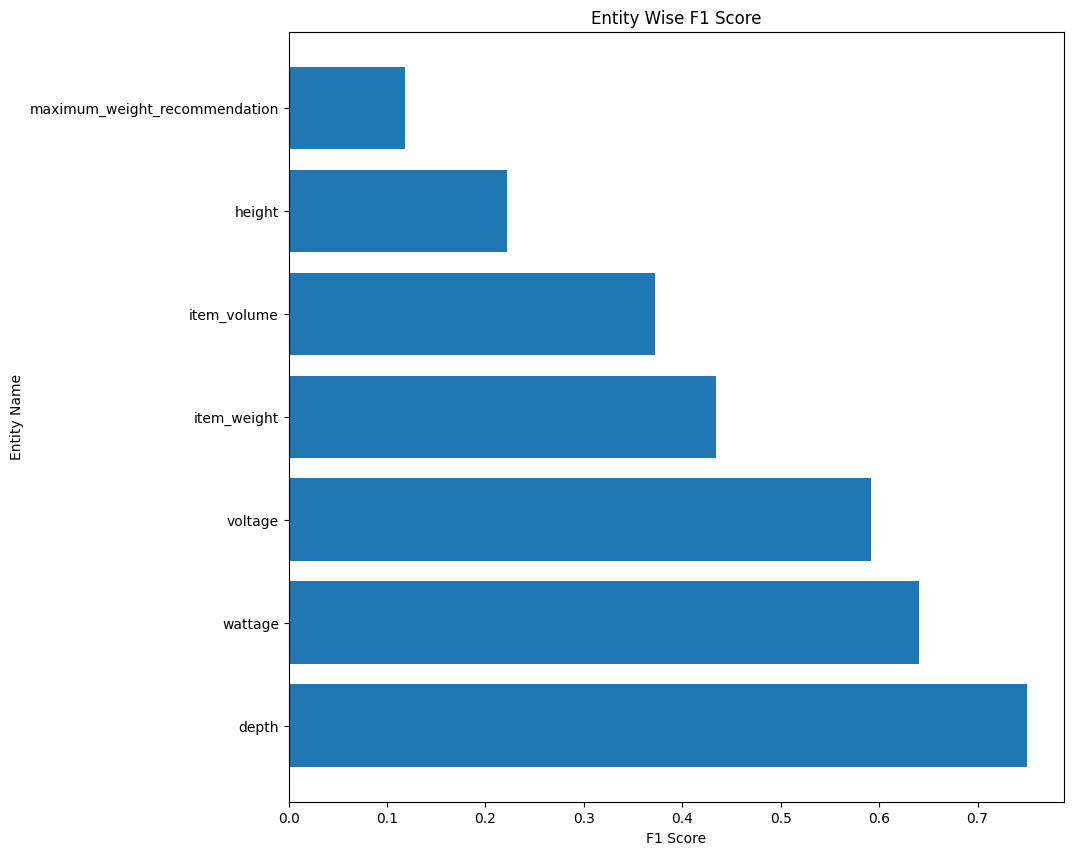

In [102]:
# Plot the entity wise results
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 10))
plt.barh(entity_wise_results.index, entity_wise_results["F1"])
plt.xlabel("F1 Score")
plt.ylabel("Entity Name")
plt.title("Entity Wise F1 Score")
plt.show()

In [57]:
context = "4.72inch/12cm E27 Socket 7.08inch/18cm AC 100-240V 60W Max Wattage 7.48inch/19cm BULBS ARE NOT INCLUDED"
entity_name = "voltage"
answer = qa_pipeline(question=voltage_question, context=context)
print(answer)

{'score': 0.030915159732103348, 'start': 42, 'end': 54, 'answer': '100-240V 60W'}


In [72]:
import re

text = "100-240V 60W, 50/60Hz, 110-220V, 230V, 12-24 volts"
pattern = r"[0-9IJOD]+(\.[0-9IJOD]+)?[-/][0-9IJOD]+(\.[0-9IJOD]+)?\s*(mv|kv|v|milli|kilo)|[0-9IJOD]+\s*(mv|kv|v|milli|kilo)"

matches = re.finditer(pattern, text, re.IGNORECASE)

for match in matches:
    print("Matched:", match.group())

Matched: 100-240V
Matched: 110-220V
Matched: 230V
Matched: 12-24 v


In [104]:
edge_case = [
    "100mm NIMH AA3000mAh 9.6v GZ190805 56mm + 14mm",
]
for case in edge_case:
    answer = qa_pipeline(question=question.replace("%%", "voltage"), context=case)
    print(process_text(answer["answer"], "voltage"))

9.6 volt
